In [96]:
import pandas as pd
from datetime import datetime, timedelta
from openpyxl import load_workbook

In [98]:
workbook_path = 'all_trends.xlsx'

In [99]:
def standardize_df(df, standard_columns):
    for col in standard_columns:
        if col not in df.columns:
            df[col] = pd.NA
    return df[standard_columns]

In [100]:
target_date = "2023-12-22"

In [101]:
standard_columns = ['Rank', 'Title', 'Platform', 'Subreddit', 'Category', 'Channel', 'Views', 'Publish_Count', 'Score', 'Subscribers', 'Comments', 'URL', 'Posted']

In [102]:
files = {
    'YouTube': 'trending_videos.xlsx',
    'US Headlines': 'us_headlines.xlsx',
    'Global Business News': 'global_business_news.xlsx',
    'Reddit': 'top_reddit_posts.xlsx',
    'Google': 'OverallTrendingSearches2.xlsx',
    'TikTok': f'tiktok_us_hashtags_{target_date}.csv'
}

In [103]:
dfs = []

In [104]:
# Process each file and look for the specific date tab
for platform, file_path in files.items():
    try:
        if file_path.endswith('.csv'):
            # Read CSV file
            df = pd.read_csv(file_path)
        else:
            # Read Excel file from the specified sheet
            df = pd.read_excel(file_path, sheet_name=target_date)

        # Keep only the top 10 entries
        df = df.head(10)

        # Standardize DataFrame columns
        df = standardize_df(df, standard_columns)

        # Populate 'Rank' column
        df['Rank'] = range(1, len(df) + 1)

        # Add 'Platform' column
        df['Platform'] = platform

        # Append DataFrame to the list
        dfs.append(df)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

In [105]:
aggregated_data = pd.concat(dfs, ignore_index=True)

In [108]:
workbook_path = "all_trends.xlsx"
book = load_workbook(workbook_path)

In [109]:
# Check if a sheet with the same name already exists
sheet_title = f'{target_date}'
if sheet_title in book.sheetnames:
    # If the sheet exists, remove it to avoid duplication
    del book[sheet_title]

In [110]:
ws = book.create_sheet(title=sheet_title)

In [111]:
from openpyxl.utils.dataframe import dataframe_to_rows
for r_idx, row in enumerate(dataframe_to_rows(aggregated_data, index=False, header=True)):
    for c_idx, value in enumerate(row):
        # Replace pandas.NA and NaN with None or an empty string
        if pd.isna(value):
            value = None
        ws.cell(row=r_idx+1, column=c_idx+1, value=value)

# Save the workbook
book.save(workbook_path)

In [112]:
# Ensure the file path is for an Excel file, not a CSV file
file_path = 'all_trends.xlsx'  # Should end with .xlsx or .xls

try:
    master_data = pd.read_excel(file_path, sheet_name='Master')
except:
    master_data = pd.DataFrame()
    
new_data = pd.read_excel(file_path, sheet_name=target_date)
new_data['Date'] = target_date  # Add a column for the date

# Check if the target date's data is already in the master sheet
if target_date not in master_data['Date'].unique():
    master_data = pd.concat([master_data, new_data])

    # Save the updated master data back to the Excel file
    with pd.ExcelWriter(file_path, mode='a', if_sheet_exists='replace', engine='openpyxl') as writer:
        master_data.to_excel(writer, sheet_name='Master', index=False)
else:
    pass

In [113]:
def normalize_scores(data, score_column):
    max_score = data[score_column].max()
    min_score = data[score_column].min()
    # Avoid division by zero in case all scores are the same
    if max_score != min_score:
        data['normalized_score'] = (data[score_column] - min_score) / (max_score - min_score)
    else:
        data['normalized_score'] = 0.5  # Arbitrary value in the middle if all scores are equal
    return data

In [114]:
reddit_data = master_data[master_data["Platform"]=="Reddit"].copy()
reddit_data = normalize_scores(reddit_data, 'Score')

In [115]:
youtube_data = master_data[master_data["Platform"]=="YouTube"].copy()
youtube_data["Views"] = youtube_data["Views"].astype(int)
youtube_data = normalize_scores(youtube_data, "Views")

In [116]:
tiktok_data = master_data[master_data["Platform"]=="TikTok"].copy()
tiktok_data = normalize_scores(tiktok_data, "Views")

In [117]:
combined_data = pd.concat([youtube_data, tiktok_data, reddit_data, master_data], ignore_index=True)

# 'combined_data' now contains all the data with the normalized scores for each platform
# Show the first few rows to verify
#combined_data.head()

In [118]:
combined_data = combined_data.drop_duplicates(subset=['Title', 'Platform', 'Date'])

In [119]:
#combined_data.shape

In [120]:
import plotly.express as px

# Convert 'Posted' to datetime
combined_data['Posted'] = pd.to_datetime(combined_data['Posted'], errors='coerce')

In [121]:
combined_data['Comments'] = pd.to_numeric(combined_data['Comments'], errors='coerce').round()
combined_data['Formatted_Comments'] = combined_data['Comments'].apply(lambda x: "{:,}".format(int(x)) if pd.notnull(x) else '')

In [122]:
combined_data['Views'] = pd.to_numeric(combined_data['Views'], errors='coerce').round()
combined_data['Formatted_Views'] = combined_data['Views'].apply(lambda x: "{:,}".format(int(x)) if pd.notnull(x) else '')

In [123]:
combined_data['Score'] = pd.to_numeric(combined_data['Score'], errors='coerce').round()
combined_data['Formatted_Score'] = combined_data['Score'].apply(lambda x: "{:,}".format(int(x)) if pd.notnull(x) else '')

In [124]:
combined_data['Publish_Count'] = pd.to_numeric(combined_data['Publish_Count'], errors='coerce').round()
combined_data['Formatted_Publish_Count'] = combined_data['Publish_Count'].apply(lambda x: "{:,}".format(int(x)) if pd.notnull(x) else '')

In [125]:
combined_data['Subscribers'] = pd.to_numeric(combined_data['Subscribers'], errors='coerce').round()
combined_data['Formatted_Subscribers'] = combined_data['Subscribers'].apply(lambda x: "{:,}".format(int(x)) if pd.notnull(x) else '')

In [126]:
def create_hover_info(row):
    # Common information to be included for all platforms
    common_info = f"Rank: {row['Rank']}\nTitle: {row['Title']}\nPlatform: {row['Platform']}\nTime Posted: {row['Posted']}"

    # Platform-specific information
    if row['Platform'] == 'YouTube':
        return f"{common_info}\nChannel: {row['Channel']}\nViews: {row['Formatted_Views']}\nSubscribers: {row['Formatted_Subscribers']}\nLikes: {row['Formatted_Score']}\nComments: {row['Formatted_Comments']}\nCategory: {row['Category']}"
    elif row['Platform'] == 'TikTok':
        return f"{common_info}\nCategory: {row['Category']}\nViews: {row['Formatted_Views']}\nPublish Count: {row['Formatted_Publish_Count']}"
    elif row['Platform'] == 'Google':
        return f"{common_info}\nCategory: {row['Category']}"
    elif row['Platform'] == 'Reddit':
        return f"{common_info}\nSubreddit: {row['Subreddit']}\nScore: {row['Formatted_Score']}\nComments: {row['Formatted_Comments']}\nURL: {row['URL']}"
    elif row['Platform'] == 'Global Business News':
        return f"{common_info}\nURL: {row['URL']}"
    elif row['Platform'] == 'US Headlines':
        return f"{common_info}\nURL: {row['URL']}"
    else:
        return common_info

# Apply the function to your DataFrame
combined_data['hover_text'] = combined_data.apply(create_hover_info, axis=1)

In [127]:
# Define the range for your circle sizes
min_marker_size = 7   # Minimum marker size
max_marker_size = 50  # Maximum marker size

# Function to determine size based on normalized_score or ranking
def calculate_scaled_size(row):
    if pd.isna(row['normalized_score']):
        # Inverse the rank (so lower ranks are bigger) and scale it
        return max_marker_size - ((row['Rank'] - 1) / combined_data['Rank'].max() * (max_marker_size - min_marker_size))
    else:
        # Scale the normalized score
        return row['normalized_score'] * (max_marker_size - min_marker_size) + min_marker_size

# Apply the function to each row
combined_data['scaled_size'] = combined_data.apply(calculate_scaled_size, axis=1)

# Ensure 'normalized_score' is of numeric type
combined_data['normalized_score'] = pd.to_numeric(combined_data['normalized_score'], errors='coerce')

In [128]:
def generate_sequential_datetimes(data, offset_hours=0):
    # Function to assign times within each date group
    def assign_times(group):
        base_datetime = pd.to_datetime(group['Date'].min()) + pd.to_timedelta(offset_hours, unit='h')
        time_difference = pd.to_timedelta(group['Rank'] - 1, unit='h')
        group['Posted'] = base_datetime + time_difference
        group['Posted'] = group['Posted'].dt.strftime('%Y-%m-%d %H:%M:%S')
        return group

    # Group by 'Date', then apply the assign_times function to each group
    data = data.groupby('Date', group_keys=False).apply(assign_times)
    return data

# Apply the function to Google data without offset
google_data = combined_data[combined_data['Platform'] == 'Google']
google_data = generate_sequential_datetimes(google_data)

# Apply the function to TikTok data with an 8-hour offset
tiktok_data = combined_data[combined_data['Platform'] == 'TikTok']
tiktok_data = generate_sequential_datetimes(tiktok_data, offset_hours=8)

# Merge the adjusted data back into the main DataFrame
combined_data.update(google_data)
combined_data.update(tiktok_data)

In [129]:
#combined_data

In [130]:
combined_data['hover_text'] = combined_data['hover_text'].str.replace('\n', '<br>')

In [131]:
combined_data = combined_data[~combined_data['Title'].str.contains('remove', case=False, na=False)]

## Bubble Plot

In [132]:
import plotly.graph_objects as go

In [133]:
combined_data = combined_data.sort_values(by=['Title', 'Date'])

In [134]:
#combined_data

In [135]:
import plotly.express as px
import plotly.graph_objects as go

# Create the initial scatter plot
fig = px.scatter(
    combined_data,
    x='Date',
    y='Rank',
    size='scaled_size',
    color='Platform',
    hover_name='Title',
    hover_data=['hover_text'],
    title='Trending Topics Over Time',
    labels={'Date': 'Date', 'Rank': 'Ranking'},
    size_max=20,
    height=800,
    render_mode='svg'
)

# Manually define a color map for platforms
platform_colors = {
    'Google': 'aqua',
    'TikTok': '#9A4C9E',
    'YouTube': '#FFC878',
    'US Headlines': 'white',
    'Reddit': 'orange',
    'Global Business News': 'blue',
    # Add other platforms and their colors here
}

# Update traces to group data by 'Title' and connect them with lines
for title, group in combined_data.groupby('Title'):
    # Get the color for the platform of this group
    platform = group['Platform'].iloc[0]
    color = platform_colors.get(platform, 'black')

    # Add line trace for each title
    fig.add_trace(go.Scatter(
        x=group['Date'], 
        y=group['Rank'], 
        mode='lines', 
        line=dict(width=2, color=color),
        name=f"{platform} - {title}",
        legendgroup=platform,
        customdata=[platform],
        showlegend=False
    ))
    
# Update the hover template for each trace
fig.update_traces(
    hovertemplate='%{customdata[0]}<extra></extra>'  # Using the first item in customdata for hover
)

# Create buttons for each platform to control visibility
buttons = []
for platform in combined_data['Platform'].unique():
    buttons.append(dict(
        label=platform,
        method="update",
        args=[{"visible": [(trace.customdata[0] == platform if trace.customdata is not None else False) for trace in fig.data]}]
    ))

# Update layout to include buttons
fig.update_layout(
    yaxis=dict(
        autorange='reversed',
        tickmode='array',
        tickvals=[i for i in range(1, 11)],
        ticktext=[str(i) for i in range(1, 11)]
    )
)

# Show the plot
fig.show()

## Weighted Word Cloud based on Trend Ranking

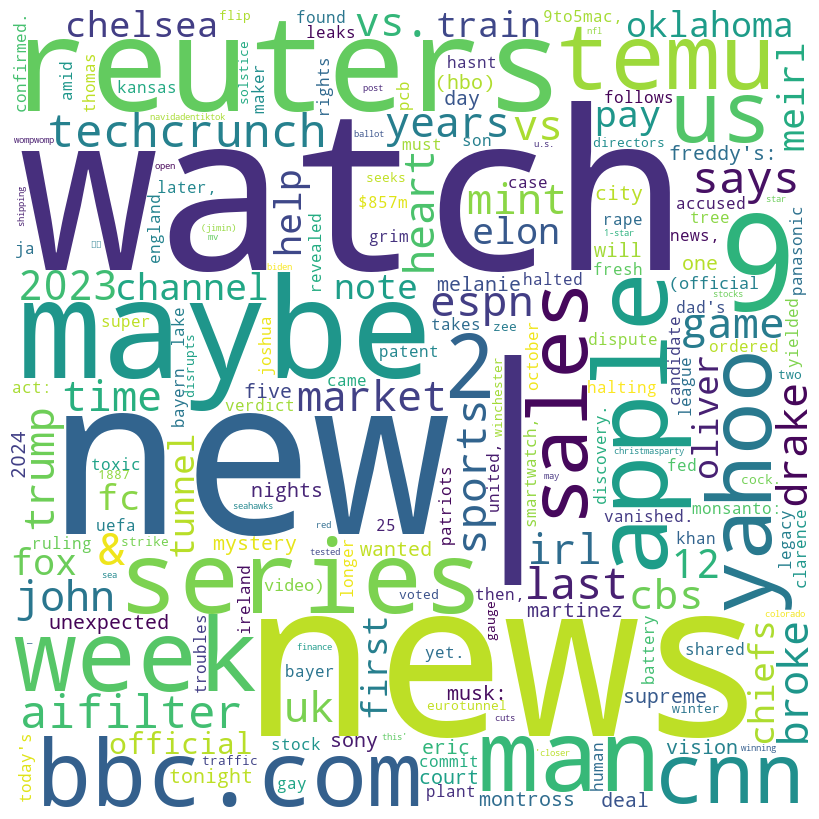

In [83]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Enhance the stopwords set by adding common words and converting to lowercase
enhanced_stopwords = set(STOPWORDS)
enhanced_stopwords.update(["the", "and", "of", "to", "in", "for", "on", "with", "at", "by", "from", "-"])

# Create a weighted frequency dictionary
weighted_words = {}
for _, row in combined_data.iterrows():
    if isinstance(row['Title'], str) and pd.notnull(row['Rank']):
        words = row['Title'].lower().split()  # Convert to lower case
        weight = 1 / row['Rank']  # Inverse of rank as weight
        for word in words:
            if word not in enhanced_stopwords:
                if word in weighted_words:
                    weighted_words[word] += weight
                else:
                    weighted_words[word] = weight

# Generate and display the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(weighted_words)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()